# Разработка рекомендаций для сети фитнес-центров по стратегии взаимодействия с клиентами на основе аналитических данных.
---

## Цели и задачи исследования.

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо. 
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас. 
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся. 

**Цель исследования: подготовить план действий по борьбе с оттоком клиентов фитнес-центра.**

**Задачи:**
1. спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. проанализировать основные признаки, наиболее сильно влияющие на отток;
4. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.

**Описание датасетов.**

В нашем распоряжении находятся  данные клиента за предыдущий до проверки факта оттока месяц и информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента. Датасет 'gym_churn.csv':

- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах);
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

Импортируем библиотеки, необходимые нам для работы.

In [15]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
import scipy.stats as st
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools
warnings.filterwarnings('ignore')

## Исследовательский анализ данных (EDA).

Загрузим датасет и проведем его первичный обзор.

In [16]:
try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('C:/Users/sutul/datasets/gym/gym_churn.csv')

In [17]:
display(df.head())
pd.set_option('display.max_columns', None)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В нашем распоряжении 14 столбцов с данными, пропусков нет. Столбцов с датами нет, категориальные переменные заданы числовыми значениями, что облегчает дальнейший анализ. На первый взгляд подготовка данных очень высокая. Построим визулизации по данным из датасета, чтобы посмотреть на распределение значений. Для категориальных значений построим столбчатые диаграммы, по дискретным величинам - гистограммы.

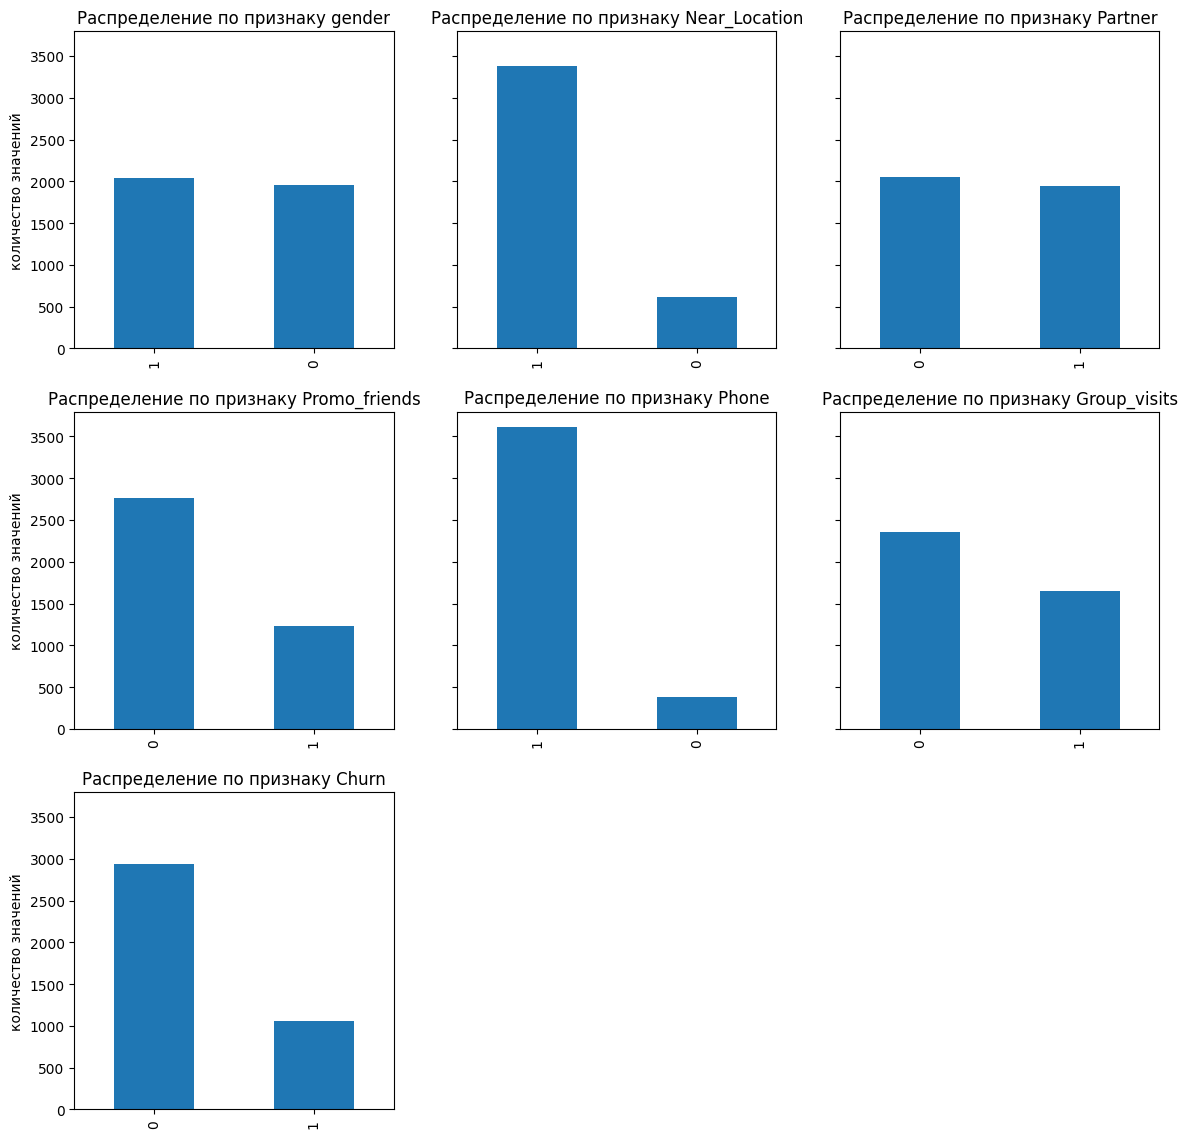

In [19]:
plt.figure(figsize=(14, 14))

ax1 = plt.subplot(3, 3, 1)
ax1 = df['gender'].value_counts().plot(kind='bar')
ax1.set_title('Распределение по признаку gender')
ax1.set(ylabel="количество значений", xlabel="")

ax2 = plt.subplot(3, 3, 2, sharey = ax1)
ax2 = df['Near_Location'].value_counts().plot(kind='bar')
ax2.set_title('Распределение по признаку Near_Location')
ax2.set(ylabel="количество значений", xlabel="")

ax3 = plt.subplot(3, 3, 3, sharey = ax1)
ax3 = df['Partner'].value_counts().plot(kind='bar')
ax3.set_title('Распределение по признаку Partner')
ax3.set(ylabel="количество значений", xlabel="")

ax4 = plt.subplot(3, 3, 4, sharey = ax1)
ax4 = df['Promo_friends'].value_counts().plot(kind='bar')
ax4.set_title('Распределение по признаку Promo_friends')
ax4.set(ylabel="количество значений", xlabel="")

ax5 = plt.subplot(3, 3, 5, sharey = ax1)
ax5 = df['Phone'].value_counts().plot(kind='bar')
ax5.set_title('Распределение по признаку Phone')
ax5.set(ylabel="количество значений", xlabel="")

ax6 = plt.subplot(3, 3, 6, sharey = ax1)
ax6 = df['Group_visits'].value_counts().plot(kind='bar')
ax6.set_title('Распределение по признаку Group_visits')
ax6.set(ylabel="количество значений", xlabel="")

ax7 = plt.subplot(3, 3, 7, sharey = ax1)
ax7 = df['Churn'].value_counts().plot(kind='bar')
ax7.set_title('Распределение по признаку Churn')
ax7.set(ylabel="количество значений", xlabel="");

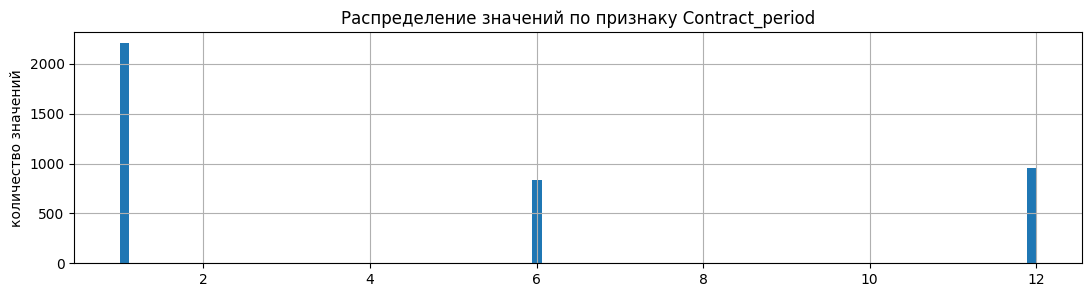

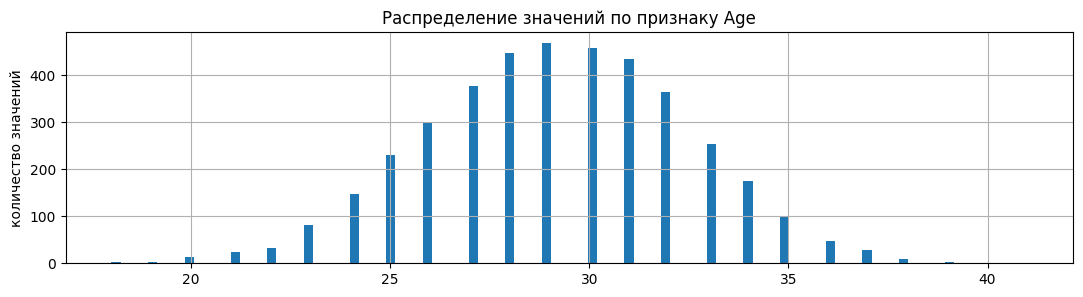

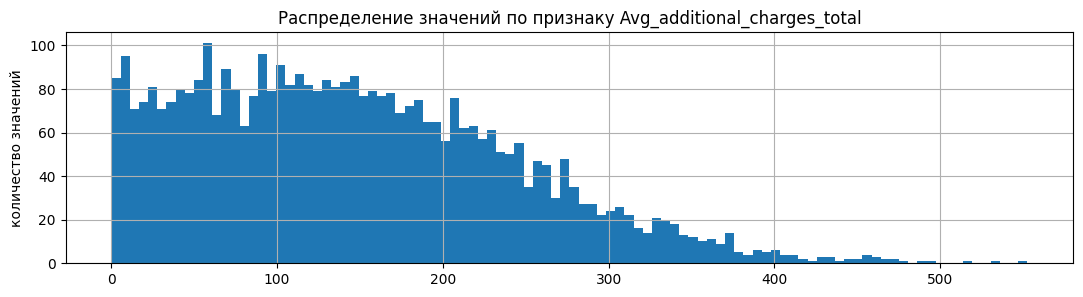

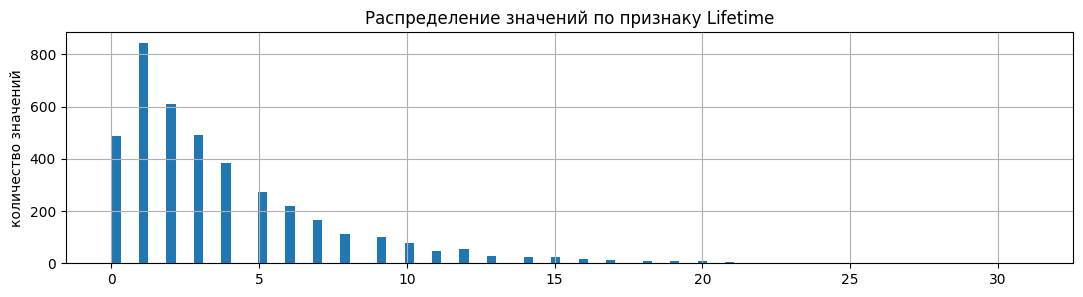

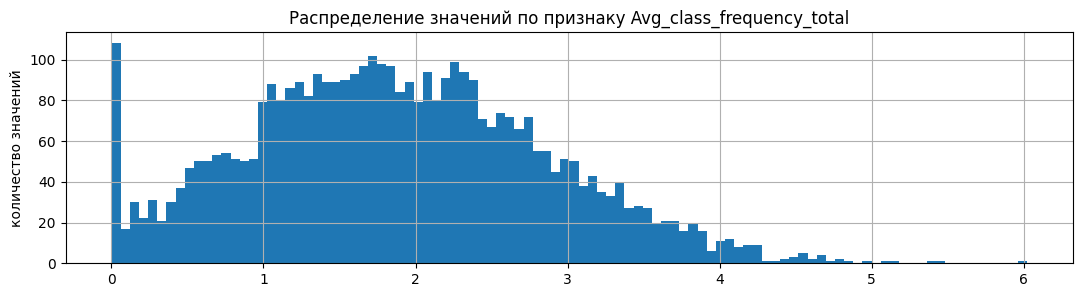

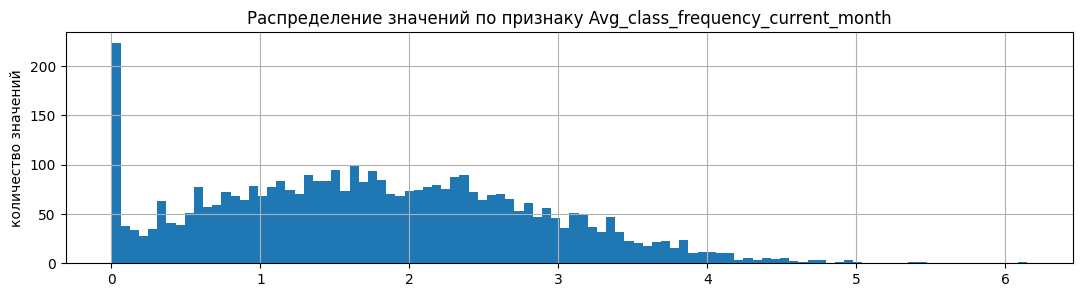

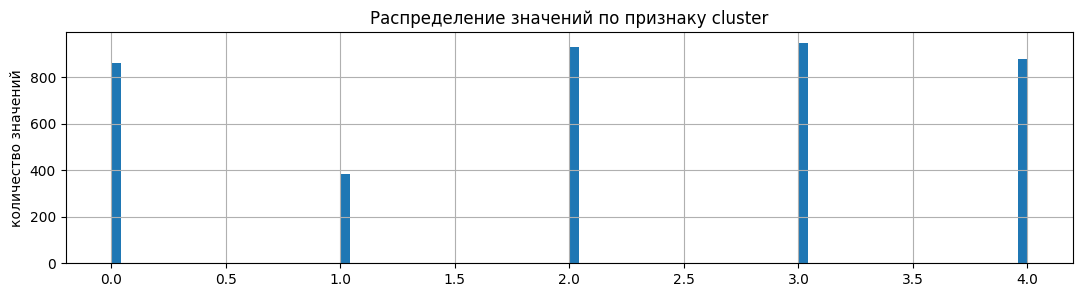

In [47]:
for col in df.columns:
    if df[col].max() > 1:
        df[col].hist(figsize=(13,3), bins=100)
        plt.title('Распределение значений по признаку ' + col)
        plt.ylabel('количество значений')
        plt.show();

Какую информацию можно извлечь из диаграмм? Сначала посмотрим на категориальные переменные:
- распределение по половому признаку почти 50:50;
- большая часть клиентов работаю или проживают не далеко от фитнес-центров;
- половина клиентов - сотрудники компаний-партнеров сети фитнес-центров;
- около четвверти клиентов пришли в фитнес-центры по рекомендации друзей;
- более, чем половина клиентов покупает месячные абонементы; 
- почти все клиенты оставляют контактный телефон для связи;
- в основном клиенты не посещают групповые занятия, но таковых не абсолютное большинство (около 2500 тыс);
- четверть всех клиентов перестали ходить в зал за последний месяц.

На дискретные величины посмотрим с помощью метода describe().

In [21]:
df[{'Age', \
    'Avg_additional_charges_total', \
    'Month_to_end_contract', \
    'Lifetime', \
    'Avg_class_frequency_total', \
    'Avg_class_frequency_current_month'}] \
.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000
Avg_class_frequency_total,4000.0,1.879020,0.972245,0.000000,1.180875,1.832768,2.536078,6.023668
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Avg_class_frequency_current_month,4000.0,1.767052,1.052906,0.000000,0.963003,1.719574,2.510336,6.146783


- В более, чем 50% случаев абонементы клиентов истекают через один месяц и только у четверти клиентов через полгода и более.
- Медианное значение выручки от дополнительных услуг фитнес-центров составляет порядка 136 у.е.
- В среднем "лайфтайм" клиента составляет 3 месяца.
- Клиенты посещают фитнес-центр где-то 2 раза в неделю.
- Средний возраст посетителей - около 30 лет.

Судя по стандартным отклонениям разброс данных по параметрам 'Month_to_end_contract' и 'Lifetime' существенный.

В целом распределение данных близко к нормальному, либо распределению Пуассона.

Сравним клиентов, которые ушли в "отток" с клиентами, которые оставлись.

In [22]:
df.groupby('Churn').median().reset_index().melt(id_vars=['Churn']).\
pivot_table(values='value', index='variable', columns='Churn').rename(columns = {0:'stay', 1:'gone'})

Churn,stay,gone
variable,,
Age,30.000000,27.000000
Avg_additional_charges_total,149.881171,103.814686
Avg_class_frequency_current_month,2.046697,0.979445
Avg_class_frequency_total,2.043252,1.491187
Contract_period,6.000000,1.000000
Group_visits,0.000000,0.000000
Lifetime,4.000000,1.000000
Month_to_end_contract,6.000000,1.000000
Near_Location,1.000000,1.000000


Те, кто ушел в "отток" в основном не работники компаний-партнеров фитнес-центров, они имеют месячные абонементы, по возрасту категории не особо отличаются, хотя те, кто ушел немного помоложе. Дополнительной выручки, закономерно, те, кто ушел приносит меньше, чем постоянные клиенты. Частота посещения фитнес-центров для тех, кто ушел - 1 раз в неделю. Постоянные клиенты ходят в среднем 2 раза в неделю.

Посмотрим на гистограммы распределения по вышеуказанным группам в отдельности по признакам. Сначала категориальные значения.

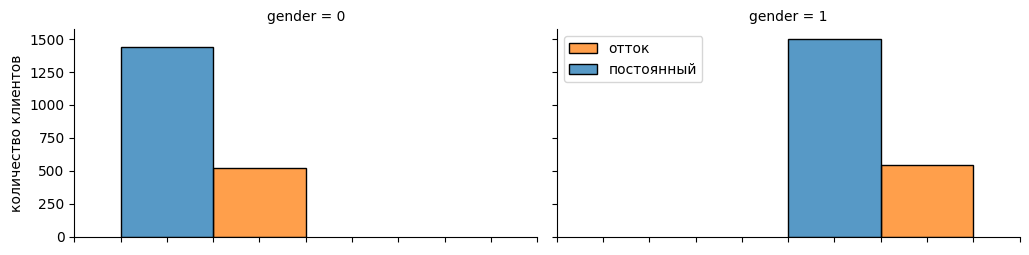

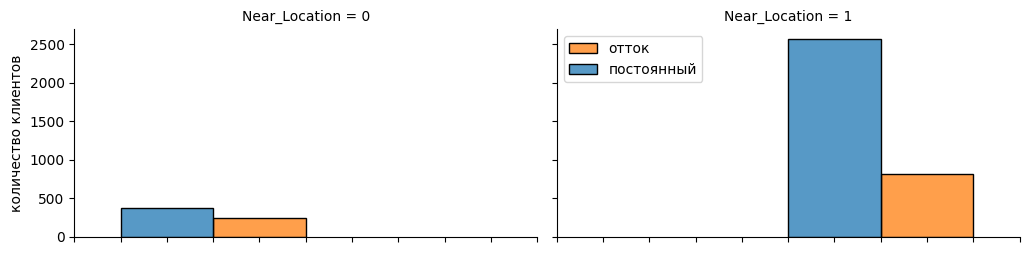

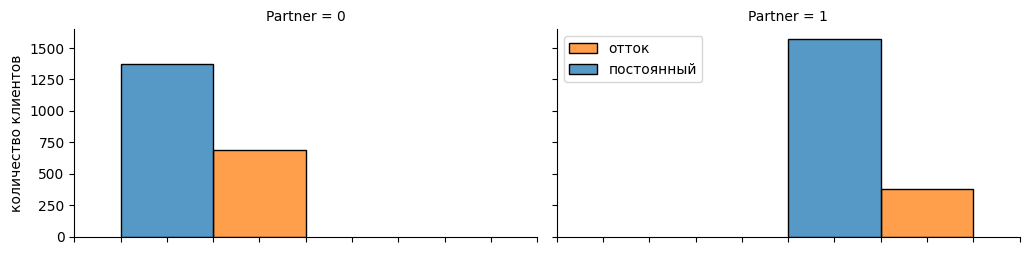

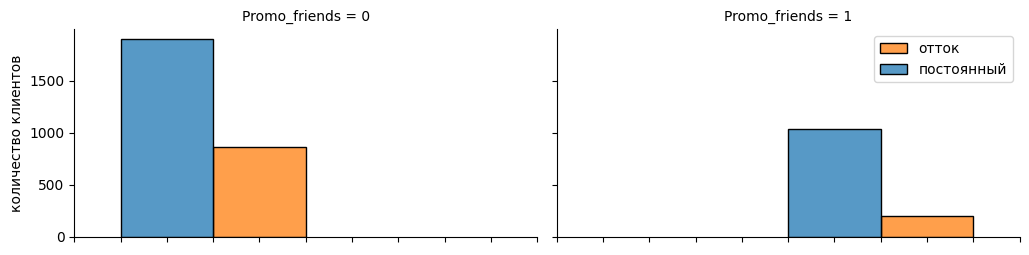

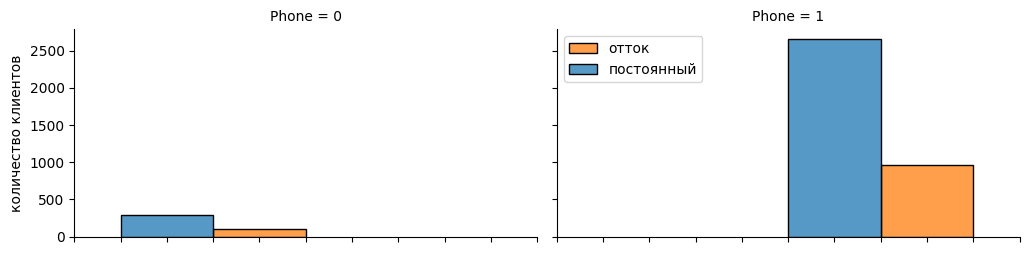

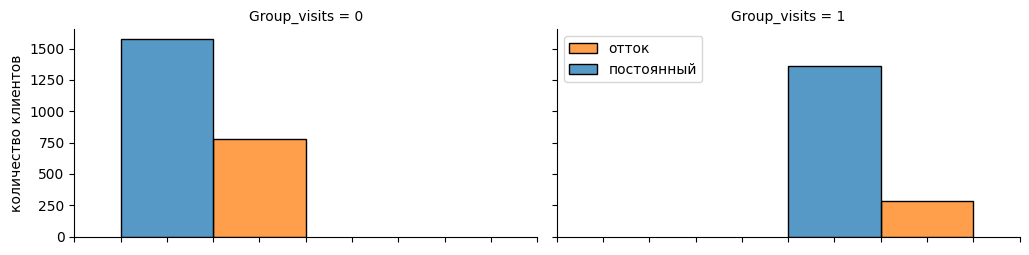

In [46]:
for col in df.columns:
    if col != 'Churn' and df[col].max() <= 1:
        g = sns.FacetGrid(df, col=col, height=3, aspect=1.7)
        g.map(sns.histplot, col, hue=df['Churn'], multiple='dodge')
        g.set(ylabel="количество клиентов", xlabel="")
        g.set_xticklabels('')
        plt.legend(['отток', 'постоянный']);

- Распределение по половому признаку примерно 50:50 в обоих группах.
- Закономерно в обоих группах посетители фитнес-центров либо живут, либо работают рядом - это удобно.
- Более половины постоянных клиентов сотрудники компаний-партнеров.
- Около 1/3 клиентов фитнес-центров пришли по рекомендациям друзей в рамках промо-акциии.
- Подавляющее большинство клиентов в обоих группах оставляют телефон для связи.
- Групповые занятия более популярны у постоянных клиентов. Около половины постоянных клиентов фитнес-центров ходят на групповые занятия, чего не скажешь о группе "оттока", там преобладают одиночки.

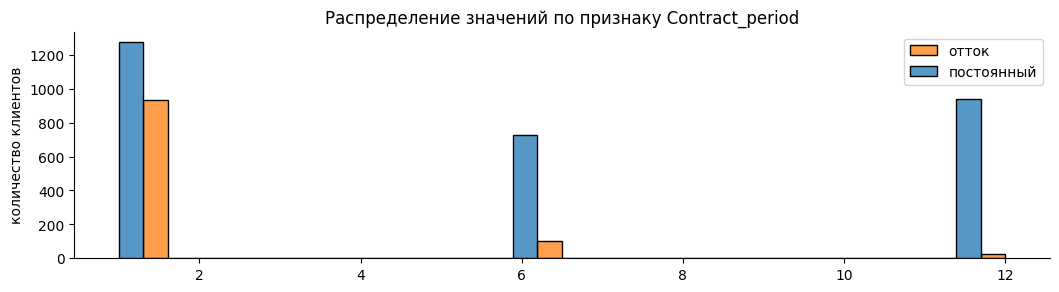

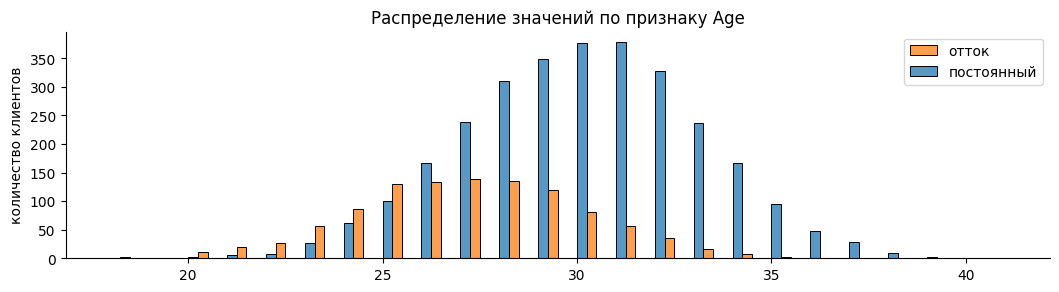

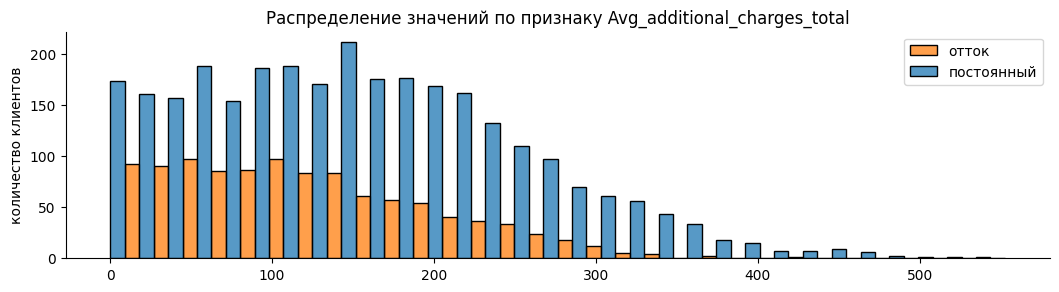

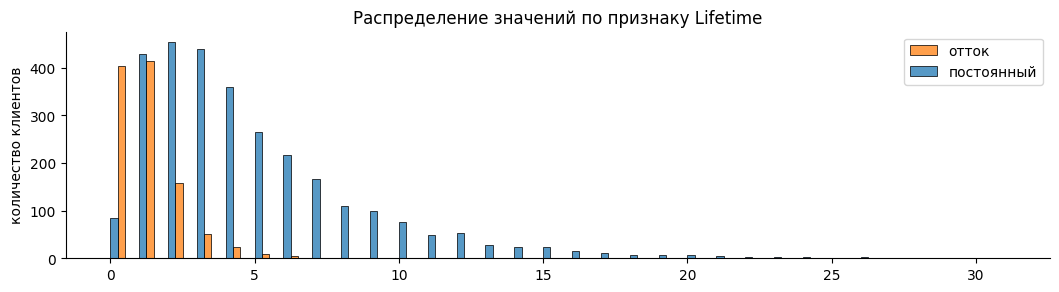

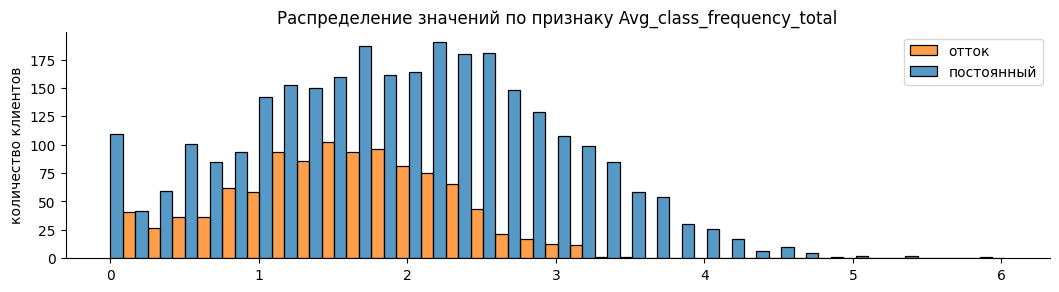

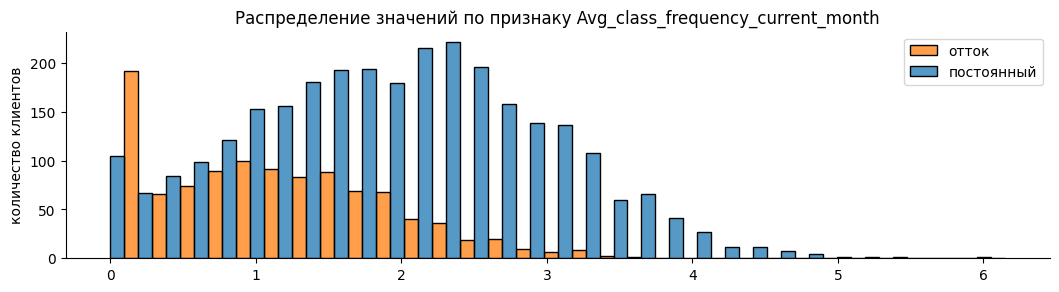

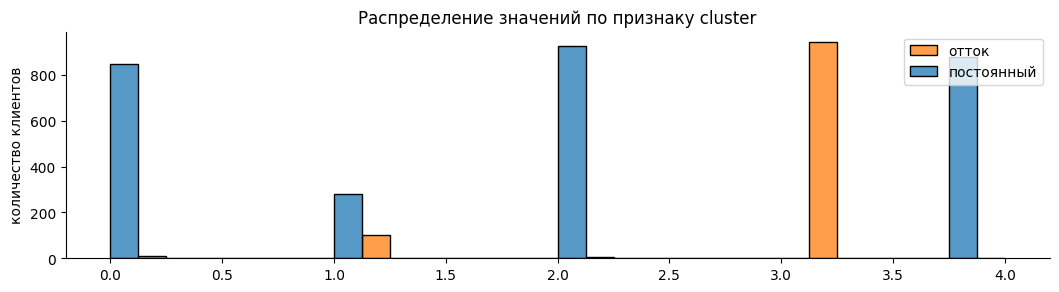

In [45]:
for col in df.columns:
    if col != 'Churn' and df[col].max() > 1:
        g = sns.FacetGrid(df, height=3, aspect=3.5)
        g.map(sns.histplot, col, hue=df['Churn'], multiple="dodge")
        g.set(ylabel="количество клиентов", xlabel="")
        plt.title('Распределение значений по признаку ' + col)
        plt.legend(['отток', 'постоянный']);

- В обоих группах преобладают месячные абонементы, однако в группе "оттока" месячные абонементы почти у всех, тогда как среди постоянных посетителей обладателей месячных абонементов немногим меньше половины.
- Распределение возрастов по пользователям по группам не сильно отличается, больше всего пользователей около 30 лет.
- Судя по распределению дополнительной выручки от пользователей постоянные клиенты охотнее пользуются дополнительными услугами фитнес-центров.
- Как бы то ни было большинство клиентов обоих групп имеют в запасе один месяц до окончания абонемента, отличие в том, что в группе постоянных клиентов около половины тех, у кого 2 и более месяцев.
- Среди постоянных клиентов в основном лайфтайм 4-5 месяцев, тогда как у группы "оттока" - 1, от силы 2.
- В распределении частоты посещения фитнес-центров кардинально различие, постоянные клиенты ходят чаще, в среднем 2 раза в неделю (как и отмечалось ранее), среди тех, кто "отпал", достаточно много таких, которые вообще не ходили. Признак 'Avg_class_frequency_total' по смыслу и арактеру распределения схож с 'Avg_class_frequency_current_month', повторятся не будем.



Посмотрим насколько признаки клиентов коррелируют между собой, для этого построим матрицу корреляций и построим по ней heatmap.

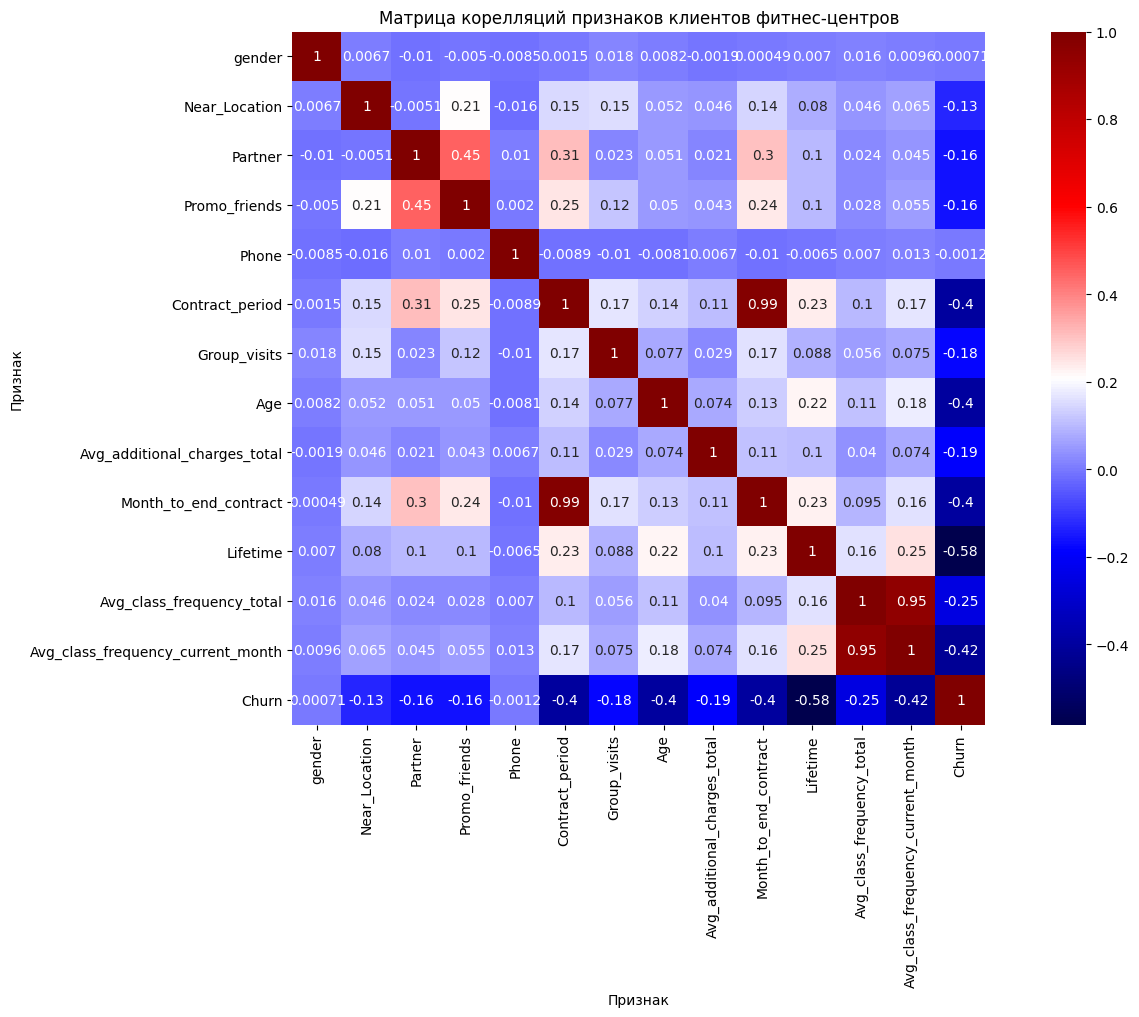

In [25]:
cm = df.corr(method ='spearman')
plt.figure(figsize=(17,9))
sns.heatmap(cm, annot=True, square=True, cmap='seismic')
plt.title("Матрица корелляций признаков клиентов фитнес-центров")
plt.xlabel('Признак')
plt.ylabel('Признак');

- Корреляции между тем постоянный клиент или клиент ушел в "отток" нет ни у одного из признаков.
- Вполне понятная высокая корреляция между признаками 'contract_period' и 'month_to_end_contact', это может стать проблемой при построении модели прогнозирования, таким образом один из этих признаков необходимо либо удалить, либо воспользоваться регуляризацией.
- Умеренная корреляция между признаками 'Partner' и 'Promo_friends' - высокая доля работников компаний-партнёров приводят друзей в фитнес-центры, также у данных признаков умеренная корреляция с признаками 'Contract_period' и 'Month_to_end_contract'.
- В остальном признаки слабо друг с другом коррелируют. 

Сформулируем основные выводы по EDA:
1. качество данных высокое (пропуски, аномалии отсутствуют, категориальные переменные заменены на числовые значения);
2. можно выделить основные особенности клиентской базы:
    - распределение по половому признаку почти 50:50 и не зависит от того постоянный это клиент или нет;
    - большая часть клиентов работают или проживают не далеко от фитнес-центров;
    - половина клиентов - сотрудники компаний-партнеров сети фитнес-центров;
    - более, чем половина клиентов покупает месячные абонементы;
    - в основном клиенты не посещают групповые занятия, но таковых не абсолютное большинство (около 2500 тыс);
    - групповые занятия более популярны у постоянных клиентов. Около половины постоянных клиентов фитнес-центров ходят на групповые занятия, чего не скажешь о группе "оттока", там преобладают одиночки.
    - четверть всех клиентов перестали ходить в зал за последний месяц.
    - в более, чем 50% случаев абонементы клиентов истекают через один месяц и только у четверти клиентов через полгода и более.
    - клиенты посещают фитнес-центр где-то 2 раза в неделю.
    - средний возраст посетителей - около 30 лет.
    - около 1/3 клиентов фитнес-центров пришли по рекомендациям друзей в рамках промо-акциии.
    - судя по распределению дополнительной выручки от пользователей постоянные клиенты охотнее пользуются дополнительными услугами фитнес-центров.
    - среди постоянных клиентов в основном лайфтайм 4-5 месяцев, тогда как у группы "оттока" - 1, от силы 2.
    - В распределении частоты посещения фитнес-центров кардинально различие, постоянные клиенты ходят чаще, в среднем 2 раза в неделю (как и отмечалось ранее), среди тех, кто "отпал", достаточно много таких, которые вообще не ходили.

3. высокая корреляция между признаками 'contract_period' и 'month_to_end_contact', это может стать проблемой при построении модели прогнозирования, таким образом один из этих признаков необходимо либо удалить, либо воспользоваться регуляризацией.
4. Умеренная корреляция между признаками 'Partner' и 'Promo_friends' - высокая доля работников компаний-партнёров приводят друзей в фитнес-центры, также у данных признаков умеренная корреляция с признаками 'Contract_period' и 'Month_to_end_contract'.     

## Построение модели прогнозирования оттока клиентов.

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

Для начала надо разбить данные на обучающую и валидационную выборку. Не забудем также удалить один из признаков 'contract_period' и 'month_to_end_contact', чтобы избежать проблемы переобучаемости модели.

In [26]:
# выберем для удаления признак 'Month_to_end_contract'
df = df.drop(labels='Month_to_end_contract', axis=1)

# разделим наши данные на признаки (матрица x) и целевую переменную (y)
x = df.drop(columns=['Churn'])
y = df['Churn']

# разделяем модель на обучающую и валидационную выборку
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify = y)

Обучим модель на train-выборке двумя способами:
- логистической регрессией,
- случайным лесом.

In [27]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
x_train_st = scaler.fit_transform(
    x_train
)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
x_test_st = scaler.transform(x_test)

In [28]:
# зададим список моделей
models = [
    LogisticRegression(solver='liblinear', random_state=0),
    RandomForestClassifier(n_estimators = 100, random_state=0),
]
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, x_train, y_train, x_test, y_test):
    model = m
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred)
        )
    )

# выведем метрики для выбранных моделей
for i in models:
    print(i)
    make_prediction(i, x_train, y_train, x_test, y_test)

LogisticRegression(random_state=0, solver='liblinear')
Accuracy:0.93 Precision:0.89 Recall:0.83
RandomForestClassifier(random_state=0)
Accuracy:0.92 Precision:0.87 Recall:0.80


**Вывод:**

По всем параметрам модель логистической регрессии дает лучший прогноз. Необходимо учесть, что распределение классов (клиентов) у нас не равное (существенное преобладание клиентов, которые не подпадают в "отток"), соответственно данная метрика будет завышенной и полагаться на неё не стоит.

## Кластеризация клиентов.

Отложим в сторону столбец с оттоком и проведём кластеризацию клиентов.

Сперва проведем стандартизацию данных.

In [29]:
scaler = StandardScaler() # создаём объект класса scaler для стандартизации
x_sc = scaler.fit_transform(df)

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков.

In [30]:
linked = linkage(x_sc, method = 'ward')

Построим дендрограмму для понимания основных категорий клиентовв, которые будет предлагать алгоритм.

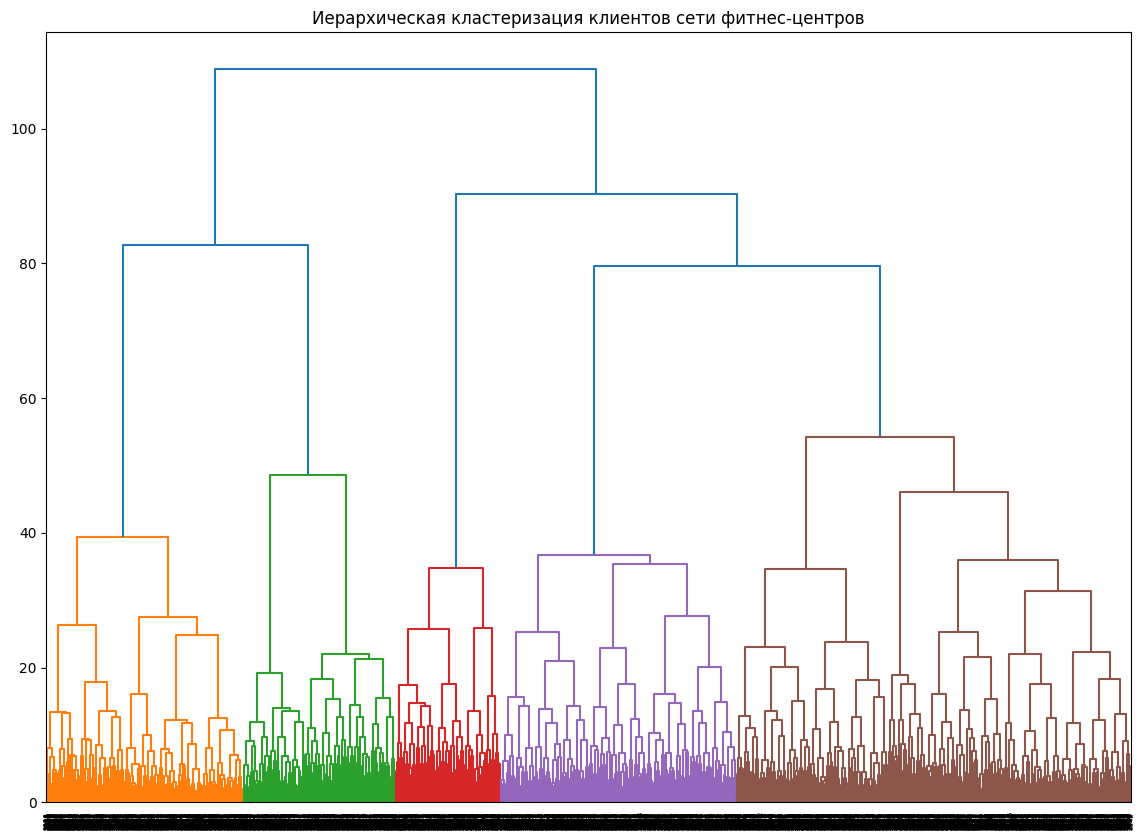

In [31]:
plt.figure(figsize=(14, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов сети фитнес-центров')
plt.show() 

Обучим также модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов (число кластеров примем равное 5 в соответствии с инструкциями по выполнению.

In [32]:
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров 

In [33]:
df['cluster'] = labels
df.groupby('cluster').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,
0,0.500581,0.970964,0.914053,0.976771,1.000000,7.782811,0.563298,29.838560,157.664951,4.662021,2.004815,2.001751,0.013937
1,0.526042,0.864583,0.473958,0.307292,0.000000,4.768229,0.427083,29.296875,144.096612,3.932292,1.851384,1.720629,0.265625
2,0.551020,0.836735,0.326531,0.059076,0.998926,4.915145,0.440387,29.972073,159.240048,4.712137,2.907233,2.912765,0.004296
3,0.508995,0.761905,0.342857,0.177778,0.998942,1.646561,0.256085,26.901587,115.450702,0.975661,1.447700,1.023574,0.996825
4,0.470990,0.812287,0.398180,0.059158,1.000000,4.620023,0.395904,30.113766,158.519785,4.625711,1.142538,1.143249,0.001138


In [34]:
    cluster_features = df.groupby('cluster').mean().reset_index()
    numeric_columns = cluster_features.drop(columns=['cluster']).columns
    cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
        .highlight_max(color='yellowgreen', subset=numeric_columns) \
        .highlight_min(color='coral', subset=numeric_columns)

,cluster,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,0.50,0.97,0.91,0.98,1.00,7.78,0.56,29.84,157.66,4.66,2.00,2.00,0.01
1,1,0.53,0.86,0.47,0.31,0.00,4.77,0.43,29.30,144.10,3.93,1.85,1.72,0.27
2,2,0.55,0.84,0.33,0.06,1.00,4.92,0.44,29.97,159.24,4.71,2.91,2.91,0.00
3,3,0.51,0.76,0.34,0.18,1.00,1.65,0.26,26.90,115.45,0.98,1.45,1.02,1.00
4,4,0.47,0.81,0.40,0.06,1.00,4.62,0.40,30.11,158.52,4.63,1.14,1.14,0.00


In [35]:
cluster_features.T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

,0,1,2,3,4
cluster,0.00,1.00,2.00,3.00,4.00
gender,0.50,0.53,0.55,0.51,0.47
Near_Location,0.97,0.86,0.84,0.76,0.81
Partner,0.91,0.47,0.33,0.34,0.40
Promo_friends,0.98,0.31,0.06,0.18,0.06
Phone,1.00,0.00,1.00,1.00,1.00
Contract_period,7.78,4.77,4.92,1.65,4.62
Group_visits,0.56,0.43,0.44,0.26,0.40
Age,29.84,29.30,29.97,26.90,30.11
Avg_additional_charges_total,157.66,144.10,159.24,115.45,158.52


Смотря на средние значения можно сразу отметить следующее:
- 0й кластер это очень активные клиенты, в основном сотрудники компаний-партнеров, активно пользуются промо-акцией "приведи друга", имеют долгосрочные абонементы, активно посещают групповые занятия, охотно пользуются дополнительными услугами фитнес-центров, ходят в фитнес-центры 2 раза в неделю и почти не попадают в "отток".
- 1й кластер это уже немного менее активные посетители, среди них немного больше мужчин, около половины сотрудников компаний-партнеров, только треть пользуется промо-акцией "приведи друга", данные посетители ценят конфиденциальность и не оставляют контактный номер телефона, однако также имеют достаточно долгосрочные абонементы, неплохо посещают групповые занятия,  хотя и посещают фитнес-центры реже, чем клиенты 0го кластера, процент "оттока" достаточно существенный.
- 2й кластер схож по признакам с 1м, за исключением того, что клиенты из 2го кластера почти не пользуеются промо-акцией, оставляют контактный телефон и посещают фитнес-центры чаще всех (в среднем 3 раза в неделю), вероятно это клиенты, серьезно настроенные поскорее набрать спортивную форму.
- 3й кластер - люди молодые и не надежные, ходят в среднем 1 раз в неделю и занимаются в среднем не более месяца.
- 4й кластер это тоже достаточно активные клиенты, а может быть и самые "интересные" для сети фитнес-центров, т.к. посещают в среднем 1 раз в неделю, но умудряются тратить на дополнительные услуги фитнес-центров столько же денег, сколько тратят клиенты из других категорий с частотой посещения 2 и 3 раза в неделю, предположим, что клиенты 4го кластера это люди, которые ходят в фитнес-центры в основном для поддержания формы.

Построим визуализации для лучшего понимания распределения признаков клиентов фитнес-центров по кластерам.

Для категориальных переменных (значения 0 или 1) построим столбчатые диаграммы.

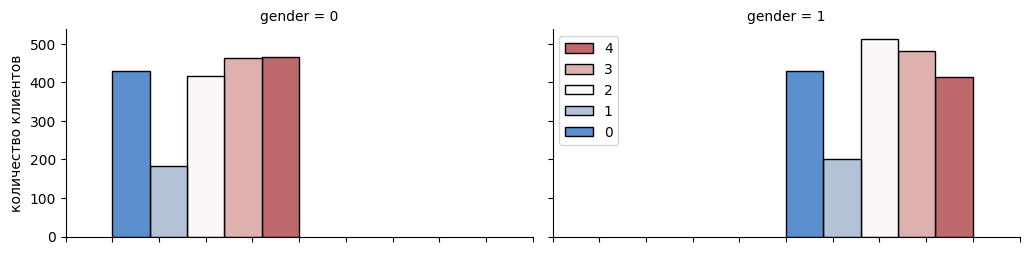

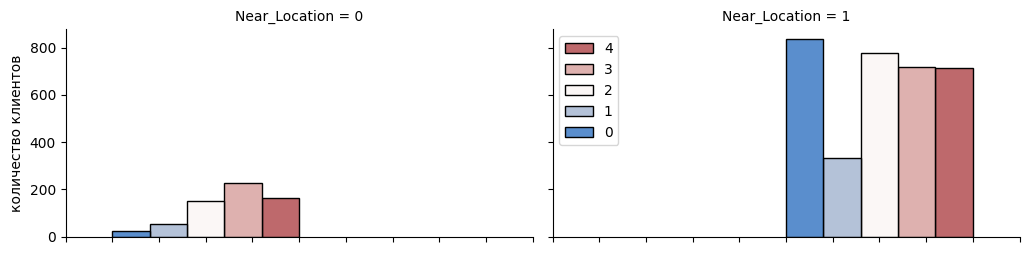

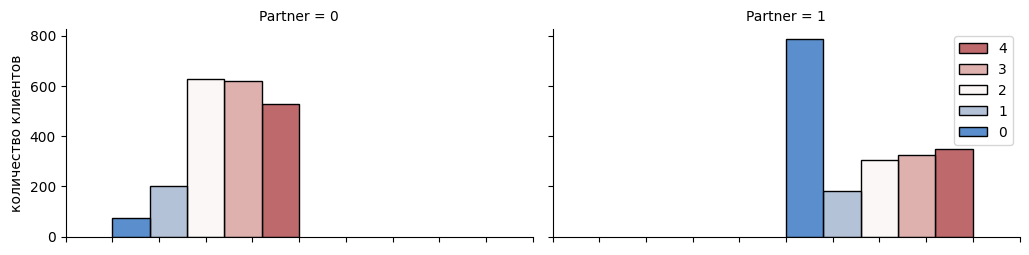

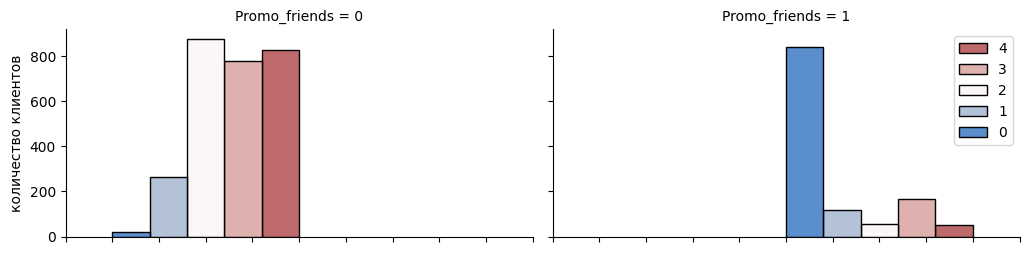

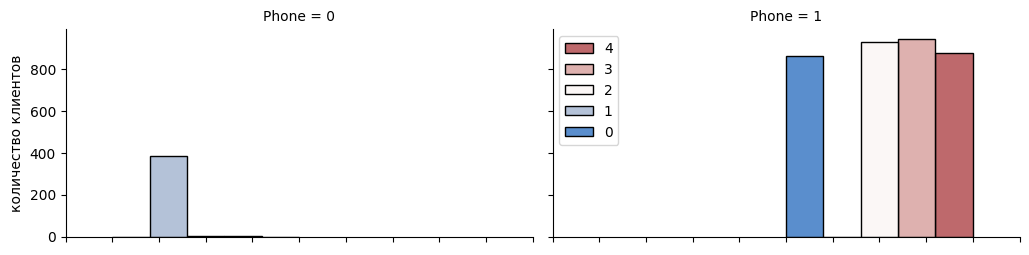

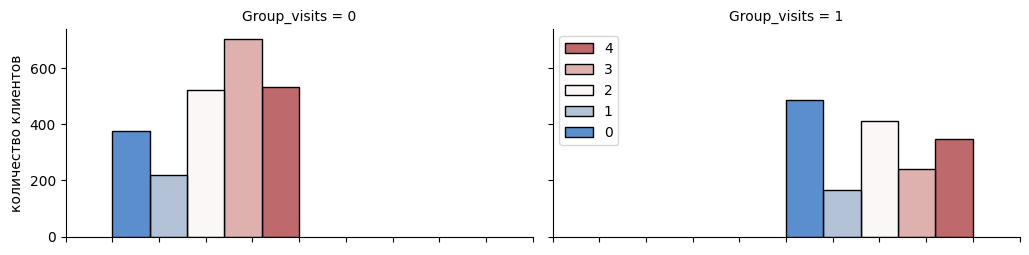

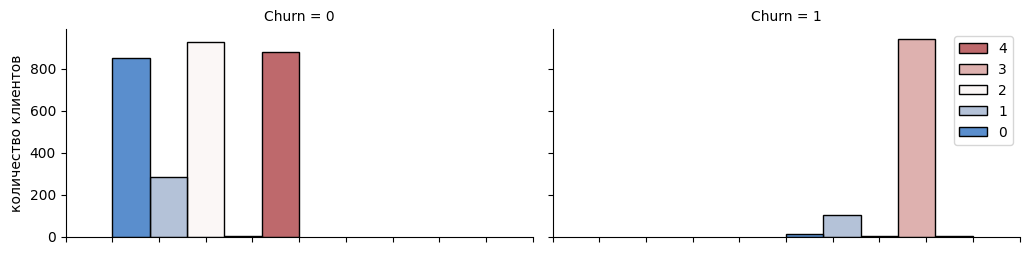

In [44]:
for col in df.columns:
    if col != 'cluster' and df[col].max() <= 1:
        g = sns.FacetGrid(df, col=col, height=3, aspect=1.7)
        g.map(sns.histplot, col, hue=df['cluster'], multiple='dodge', palette="vlag")
        g.set(ylabel="количество клиентов", xlabel="")
        g.set_xticklabels('')
        plt.legend(['4', '3', '2', '1', '0']);

По числовым значениям построим гистограммы.

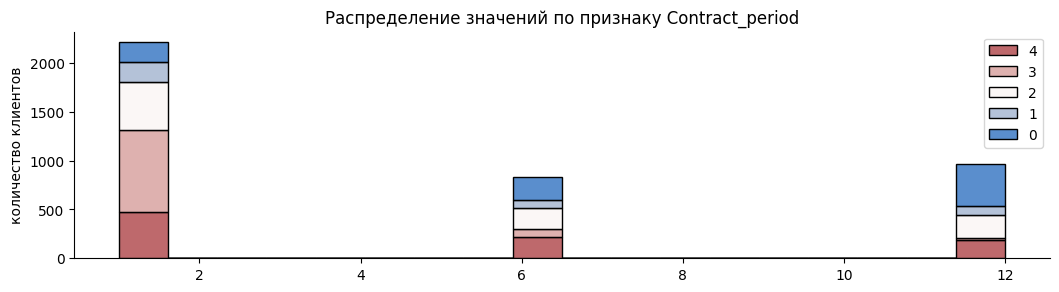

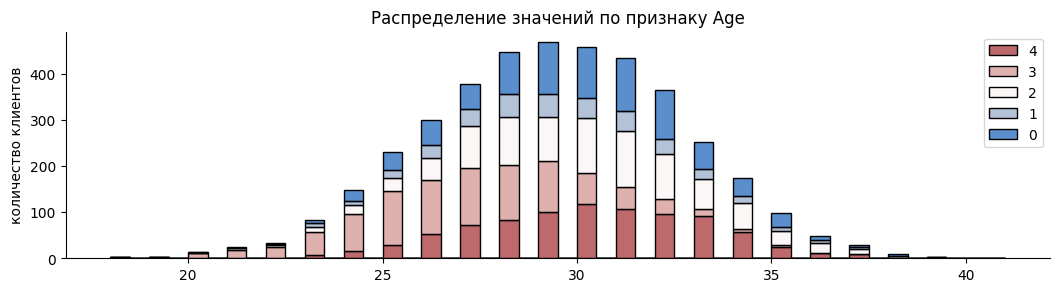

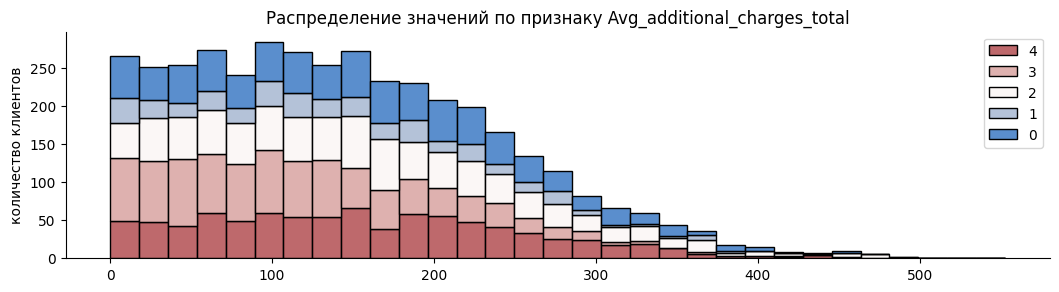

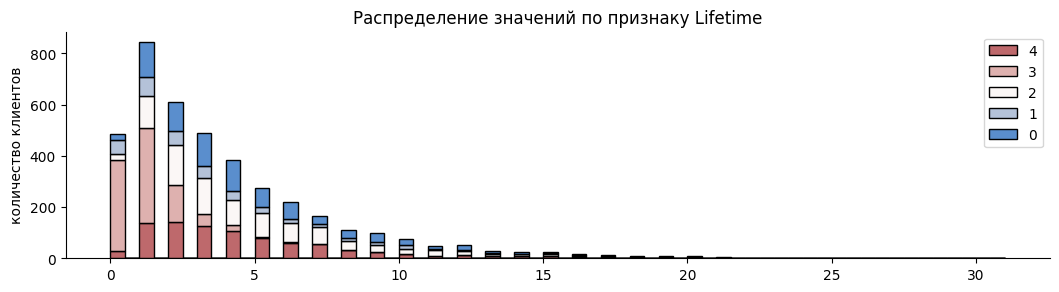

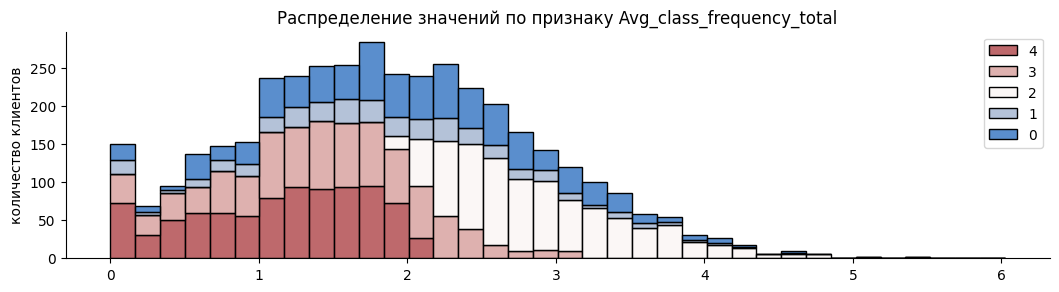

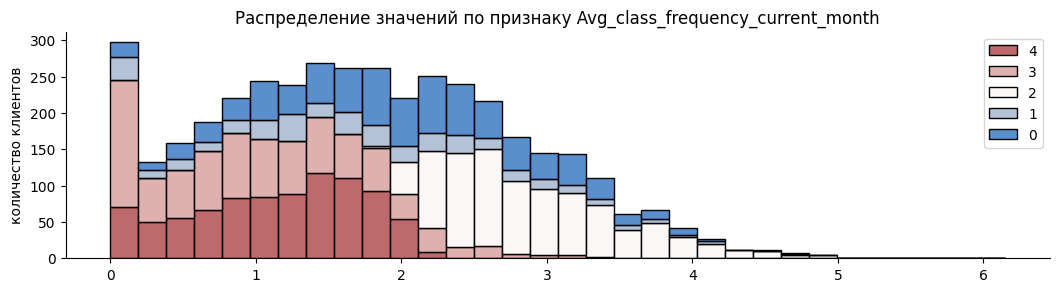

In [43]:
for col in df.columns:
    if col != 'cluster' and df[col].max() > 1:
        g = sns.FacetGrid(df, height=3, aspect=3.5)
        g.map(sns.histplot, col, hue=df['cluster'], multiple="stack", palette="vlag")
        g.set(ylabel="количество клиентов", xlabel="")
        plt.title('Распределение значений по признаку ' + col)
        plt.legend(['4', '3', '2', '1', '0']);

- основная масса клиентов предпочитают месячные абонементы, обратная ситуация только в 0м кластере.
- в 4м кластере возраст смещен за отметку 30 лет, тогда как в 0-2 кластерах возраст распределен достаточно равномерно.
- достаточно много "мертвых душ" - те, кто не посещал ни разу (в 4м и особенно в 3м кластере).
- 2й кластер - очень системные и стабильные посетители, частота посещения от 2 раз в неделю и выше.


Для каждого полученного кластера посчитаем долю оттока.

In [38]:
df.query('Churn == 1').groupby('cluster')['Churn'].count()/df.groupby('cluster')['Churn'].count()*100

cluster
0     1.393728
1    26.562500
2     0.429646
3    99.682540
4     0.113766
Name: Churn, dtype: float64

3й кластер, как и ранее указывалось самый ненадежный, почти все клиенты из этой когорты попадают в "отток". 1й кластер тоже не слишком надежен, но в "отток" попадают только 27% клиентов. Рекомендации для стратегии удержания клиентов сформулируем в общих выводах к исследованию вместе с кратким описанием основных признаков, характеризующих разные группы клиентов.

## Выводы по результатам исследования и рекомендации для стратегии удержания клиентов.

Получив данные сети фитнес-центров мы провели исследовательский анализ, по результатам которого отметили высокий уровень подготовки данных к анализу, а также сформировали представление о распределении признаков клиентов фитнес-центров в целом, проверили степень корреляции между признаками, выявили мультиколлинеарность двух признаков.

Далее, на основании метрик определили наиболее подходящую модель прогнозирования "оттока" клиентов - линейная регрессия.

Используя модель кластеризации на основании алгоритма K-Means мы распределили клиентов на 5 кластеров, по результатам исследования их можно охарактеризовать следующим образом:
- 0й: самые активные по всем признакам клиенты, в основной своей массе сотрудники компаний-партнеров, пользующиеся дисконтами;
- 1й: посетители средней активности, около половины сотрудников компаний-партнеров, данные посетители ценят конфиденциальность и не оставляют контактный номер телефона, половина имеют долгосрочные абонементы однако процент "оттока" достаточно существенный (почти 27%).
- 2й: кластер схож по признакам с 1м, за исключением того, что клиенты из 2го кластера почти не пользуеются промо-акцией, оставляют контактный телефон и посещают фитнес-центры чаще всех (в среднем 3 раза в неделю), вероятно это клиенты, серьезно настроенные поскорее набрать спортивную форму.
- 3й: люди молодые и не надежные, ходят в среднем 1 раз в неделю и занимаются в среднем не более месяца, достаточно высокая доля клиентов, которые не живут и не работают поблизости.
- 4й: достаточно активные клиенты, а может быть и самые "интересные" для сети фитнес-центров, т.к. посещают в среднем 1 раз в неделю, но умудряются тратить на дополнительные услуги фитнес-центров столько же денег, сколько тратят клиенты из других категорий с частотой посещения 2 и 3 раза в неделю

Количество клиентов по кластерам:

In [39]:
df['cluster'].value_counts()

3    945
2    931
4    879
0    861
1    384
Name: cluster, dtype: int64

**Рекомендации**

На чём необходимо сосредоточиться - 3й кластер самый многочисленный и процент "оттока" - почти 100%, 1й кластер с "оттоком" 27% не очень многочисленный, но им тоже можно было бы позаниматься. Попробуем сформулировать рекомендации по стратегии удержания клиентов:
1. Для удержания молодых клиентов необходимы специальные предложения по долгосрочным абонементам для студентов, возможно организация каких-то  мероприятий по вовлечению данной категории клиентов в фитнес-тусовку;
2. Для снижения % оттока клиентов из 3го кластера предлагается провести дополнительное исследование на предмет географии места жительства/работы данных клиентов (это будет также полезно и для 1го кластера), чтобы рассмотреть вопрос об открытии дополнительных фитнес-центров, либо как альтернативный вариант, предусмотреть компенсацию транспортных расходов клиентов (если вопрос в этом), либо увеличить время работы фитнес-центров (если вопрос в том, что кто-то не успевает доехать и нормально позаниматься).
3. Провести дополнительные маркетинговые исследования по первым 2м пунктам с целевыми категориями клиентов.